# Unsupervised Domain Adaptation

#### Installing the required libraries

In [1]:
!pip install torchinfo

#### Loading in the required libraries

In [11]:
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchinfo import summary
from tqdm import tqdm
import torch.optim as optim
from sklearn.manifold import TSNE
import numpy as np

#### Mounting the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Setting the drive path to the folder

In [4]:
path = '/content/drive/MyDrive/ATML_PA5'
# Setting the path to this folder
os.chdir(path)
# Checking the current working directory
print(os.getcwd())

/content/drive/MyDrive/ATML_PA5


#### Setting the device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device is: ", device)

The device is:  cuda


## Loading in the OFFICE-31 dataset

In [6]:
data_path = 'OFFICE31'
amazon_path = os.path.join(data_path, 'amazon')
webcam_path = os.path.join(data_path, 'webcam')
dslr_path = os.path.join(data_path, 'dslr')

print('amazon_path:', amazon_path)
print('webcam_path:', webcam_path)
print('dslr_path:', dslr_path)

# Defining the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Loading in the datasets for each of the domains
amazon_dataset = datasets.ImageFolder(amazon_path, transform=transform)
webcam_dataset = datasets.ImageFolder(webcam_path, transform=transform)
dslr_dataset = datasets.ImageFolder(dslr_path, transform=transform)

# Defining the dataloaders
batch_size = 64
amazon_dataloader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
webcam_dataloader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
dslr_dataloader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Checking the size of the datasets
print('Amazon dataset size:', len(amazon_dataset))
print('Webcam dataset size:', len(webcam_dataset))
print('DSLR dataset size:', len(dslr_dataset))

amazon_path: OFFICE31/amazon
webcam_path: OFFICE31/webcam
dslr_path: OFFICE31/dslr
Amazon dataset size: 2837
Webcam dataset size: 795
DSLR dataset size: 508


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Visualizing images from each domain

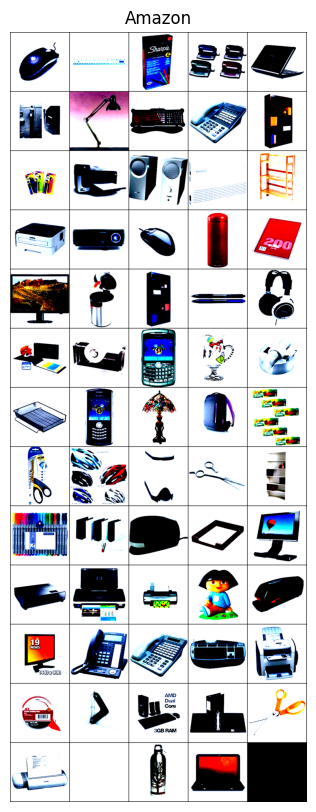

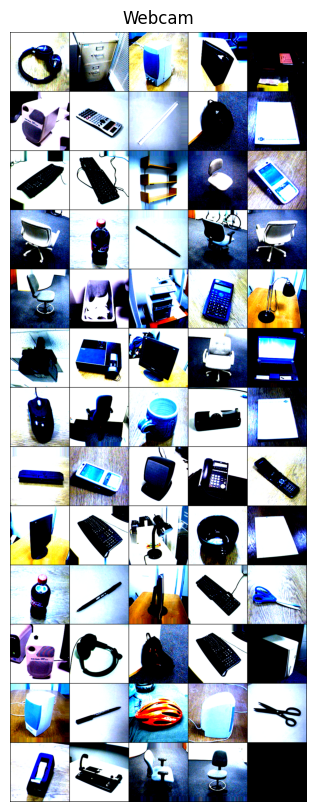

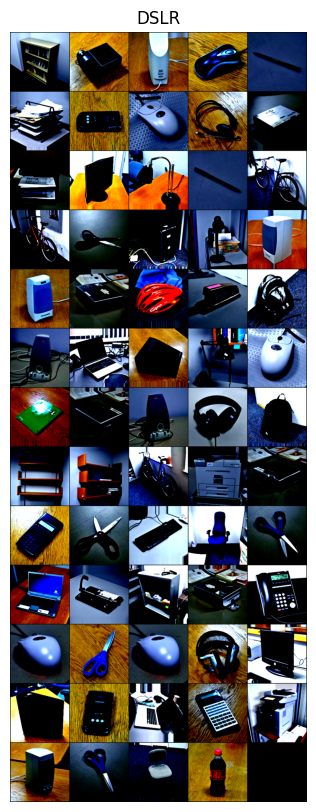

In [33]:
# Visualizing 5 images from each of the domains
def show_images(dataloader, domain_name):
    images, _ = next(iter(dataloader))
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(domain_name)
    plt.imshow(make_grid(images, nrow=5).permute(1, 2, 0))
    plt.show()

show_images(amazon_dataloader, 'Amazon')
show_images(webcam_dataloader, 'Webcam')
show_images(dslr_dataloader, 'DSLR')

## ResNet 50 Experiments

#### Loading in the ResNet 50 model and modifying the feature extractor backbone for Office 31 classification

In [7]:
# Loading in the resnet model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Checking the model summary
summary(model, input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

#### Modifying the feature extractor

In [8]:
num_classes = len(amazon_dataset.classes)
print("The number of classes is: ", num_classes)

# Modifying the final layer of the model to output the number of classes
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
# Sending the updated model to the device
model = model.to(device)

# Checking the updated model summary to verify the changes
summary(model, input_size=(1, 3, 224, 224))

The number of classes is:  31


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 31]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [9]:
# Single function for loading in the resnet model and modifying the final layer
def load_resnet_model(num_classes):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
    model = model.to(device)
    return model

# Loading in the resnet model with the updated final layer
model = load_resnet_model(num_classes)

# Sending the model to the device
model = model.to(device)

# Checking the model summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 31]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

#### Defining the function for training and testing

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

#### First experiment A -> W

In [36]:
model_A_to_W = load_resnet_model(num_classes)

# Training the model on the Amazon dataset
train_model(model_A_to_W, amazon_dataloader, optimizer, criterion, num_epochs=5)

# Evaluating the model on the Webcam dataset
evaluate_model(model_A_to_W, webcam_dataloader)

Epoch 1/5: 100%|██████████| 45/45 [03:19<00:00,  4.44s/it]


Epoch [1/5], Loss: 3.4471


Epoch 2/5: 100%|██████████| 45/45 [00:31<00:00,  1.43it/s]


Epoch [2/5], Loss: 3.4503


Epoch 3/5: 100%|██████████| 45/45 [00:29<00:00,  1.51it/s]


Epoch [3/5], Loss: 3.4504


Epoch 4/5: 100%|██████████| 45/45 [00:30<00:00,  1.50it/s]


Epoch [4/5], Loss: 3.4495


Epoch 5/5: 100%|██████████| 45/45 [00:30<00:00,  1.47it/s]

Epoch [5/5], Loss: 3.4500


Accuracy: 1.38%


1.3836477987421385

In [37]:
# Saving the trained model
torch.save(model_A_to_W, 'baseline_model_amazon_to_webcam.pth')

#### Loading in the saved model and doing feature visualization

<ipython-input-14-cc72339c6990>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('baseline_model_amazon_to_webcam.pth')


Extracting features from Amazon (source)...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Extracting features from Webcam (target)...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


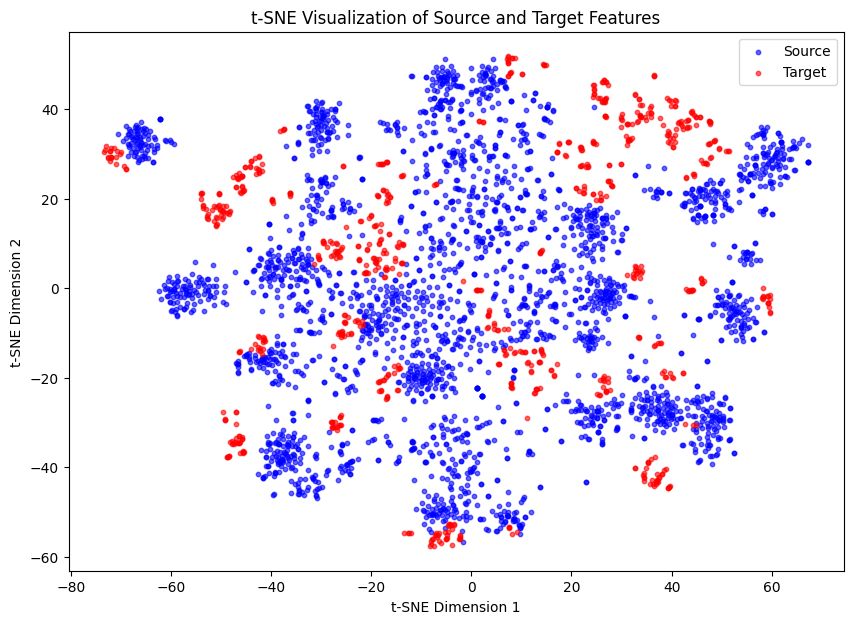

In [14]:
# Define a feature extractor from the trained model
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # All layers except the final FC layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten the feature map

# Function to extract features
def extract_features(feature_extractor, dataloader):
    feature_extractor.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = feature_extractor(images)  # Extract features
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())

    return np.concatenate(features), np.concatenate(labels)


# Load the trained model weights
num_classes = len(amazon_dataset.classes)
model = load_resnet_model(num_classes)
model = torch.load('baseline_model_amazon_to_webcam.pth')
model = model.to(device)

# Create a feature extractor
feature_extractor = FeatureExtractor(model).to(device)

# Extract features from source (Amazon) and target (Webcam)
print("Extracting features from Amazon (source)...")
source_features, source_labels = extract_features(feature_extractor, amazon_dataloader)

print("Extracting features from Webcam (target)...")
target_features, target_labels = extract_features(feature_extractor, webcam_dataloader)

# Combine features for t-SNE
features = np.vstack((source_features, target_features))
domains = np.array(['Source'] * len(source_features) + ['Target'] * len(target_features))

# Apply t-SNE to reduce to 2D
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features)

# Plot t-SNE results
plt.figure(figsize=(10, 7))
for domain, color in zip(['Source', 'Target'], ['blue', 'red']):
    indices = domains == domain
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=domain, alpha=0.6, s=10, c=color)

plt.title("t-SNE Visualization of Source and Target Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()